# RNN Predict Observation at Next Time Step

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

## Prepare Input Data

In [2]:
from collections import Counter

In [3]:
fname = "data/deu_news_2020_30K-sentences.txt"
rarechar = '❓' # use this for any character not in the alphabet

# at first determine the alphabet on first read
txt_file = open(fname, "r")
text = txt_file.read().replace('\n', '')
print ("First 10 characters of text:", text[:10])
charfreqs = Counter(text)
sorted_chars = sorted(charfreqs.items(), key=lambda x: x[1], reverse=True)
s = 96 # alphabet size
# print(sorted_chars[:s-1])
print(f"The corpus contains {len(charfreqs)} different characters. Taking only {s-1} most frequent ones:")
alphabet = ""
for i, (c, f) in enumerate(sorted_chars[:s-1]):
    print (f"{i:>3} {c} {f:>6}")
    alphabet += c
alphabet += rarechar
print (f"alphabet:{alphabet}")

# translate from character to index in {0,1,2,3}
nuc_idx = dict((c,i) for i,c in enumerate(alphabet))

def charseq2idxseq(line:str):
    x = [s-1] * len(line) # initialize with s-1 for rare or unknown character
    for i, c in enumerate(line):
        try:
            x[i] = nuc_idx[c]
        except:
            pass # handled in initialization
    return x

# on second read store the text to a sequence of numbers
seqlst = []
txt_file.seek(0) # go to the start of file again
for line in txt_file:
    line = line.rstrip() # remove trailing white spaces, here one newline
    x = charseq2idxseq(line)
    seqlst.append(x)
txt_file.close()
num_sentences = len(seqlst)
x_train_raw = np.array(seqlst, dtype=object)
print (f"number of sentences = {num_sentences}")
print (x_train_raw[0][:10])

First 10 characters of text: «2019 war 
The corpus contains 161 different characters. Taking only 95 most frequent ones:
  0   429860
  1 e 421632
  2 n 260480
  3 i 206284
  4 r 192553
  5 t 163515
  6 s 150272
  7 a 147159
  8 d 112410
  9 h 104914
 10 u  95172
 11 l  92577
 12 o  72815
 13 g  72248
 14 c  68122
 15 m  63110
 16 b  43386
 17 f  39345
 18 w  31353
 19 k  31187
 20 .  30892
 21 z  29362
 22 ,  23169
 23 v  18932
 24 p  18719
 25 S  18015
 26 ü  16493
 27 D  15084
 28 ä  14865
 29 A  13258
 30 B  11477
 31 M  11115
 32 -  10255
 33 E   9426
 34 P   8711
 35 K   8402
 36 F   8395
 37 W   7915
 38 G   7407
 39 ö   6932
 40 T   6703
 41 0   6600
 42 V   6361
 43 R   6079
 44 L   5845
 45 I   5662
 46 H   5621
 47 N   4660
 48 U   4568
 49 1   4459
 50 C   4434
 51 "   4191
 52 2   4116
 53 ß   3961
 54 Z   3848
 55 J   3750
 56 j   3015
 57 :   3008
 58 y   2887
 59 O   2415
 60 “   2105
 61 3   1942
 62 (   1886
 63 )   1877
 64 5   1830
 65 „   1795
 66 x   1545
 67 9   

In [4]:
# convert variable length lists to fixed-length array by 
# clipping longer sequences and padding shorter sequences with -1
x_train = tf.keras.preprocessing.sequence.pad_sequences(
    x_train_raw, padding="post", maxlen=100, value = -1)
# Add 1 so 0 stands for missing value
x_train = x_train + 1

In [5]:
print ("input shape: ", x_train.shape)
x_train[:2,:]

input shape:  (30000, 100)


array([[76, 53, 42, 50, 68,  1, 19,  8,  5,  1,  2,  4,  3,  1, 10,  2,
         5,  8, 11,  7, 18, 13,  5,  9,  2,  5,  3,  9,  2,  7,  1, 56,
         8, 10,  5,  1, 16,  4,  6,  1,  7,  6,  8,  5, 20,  2, 16,  1,
        19,  2, 12,  6, 19,  4,  5,  6,  7, 15, 10,  8, 18,  6, 12,  4,
        15, 10,  2, 16,  1, 39,  2, 14,  2,  3, 19,  4,  3,  9, 75, 23,
         1,  7,  8, 14,  6,  2,  1, 31,  5, 11,  9,  2,  5, 16, 27, 12,
        12,  2,  5, 21],
       [76, 53, 42, 53, 42,  1,  8,  3,  3, 13,  1, 25,  8,  3,  9,  2,
        16,  4, 15, 13,  1, 51, 13,  5, 13,  3,  8, 24,  4,  5, 11,  7,
        75,  1,  7,  6,  2, 10,  6,  1, 14,  8,  3, 22,  1, 13, 17,  2,
         3,  1,  8, 11, 18,  1,  9,  2,  5,  1, 41,  8, 18,  2, 12, 21,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]], dtype=int32)

### count character frequencies in training set

In [6]:
char_freqs = tf.reduce_mean(tf.one_hot(x_train, depth=s+1), axis=[0,1]).numpy()
char_freqs = char_freqs[1:]
char_freqs /= np.sum(char_freqs)
# print ("frequencies of characters", char_freqs)

Text(0.5, 1.0, 'Most frequent characters and their relative log-frequency')

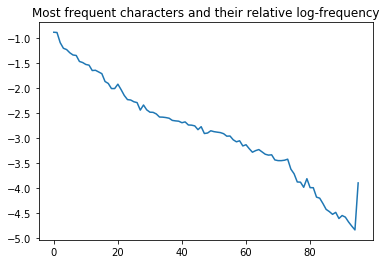

In [7]:
import matplotlib.pyplot as plt
plt.plot(range(s), np.log10(char_freqs))
plt.title("Most frequent characters and their relative log-frequency")

In [8]:
# From this, a trivial baseline cross-entropy error of a constant estimator can be estimated.
baseline_accuracy = np.sum(- char_freqs * np.log(char_freqs))
print (f"baseline_accuracy = {baseline_accuracy:.4f}")

baseline_accuracy = 3.2156


## Make TF Dataset
Here, we do not need the labels (exon or not). Instead we try to predict the $i$-th character from input sequence up to $i-1$. E.g. the training output 
from "attcac" could be "ttcacg".

In [9]:
def future_sequence(sequence):
    input_seq = sequence[:-1]
    target_seq = sequence[1:]
    target_seq = tf.one_hot(target_seq, depth=s+1)
    target_seq = target_seq[:,1:]
    return input_seq, target_seq

# future_sequence([1,4,4,1,1,2,3])

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.map(future_sequence)
train_ds = train_ds.shuffle(20000).batch(32, drop_remainder=True)
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

for (a, b) in train_ds.take(1):
    print("shape of training example", a.shape, "output", b.shape)
    print("training example", a[0,:10])
    # print("output", b[0,:10])

shape of training example (32, 99) output (32, 99, 96)
training example tf.Tensor([28  2  3  3  1 30 11  7  7  8], shape=(10,), dtype=int32)


## Prepare Model

In [11]:
units=512
rnn_simple = tf.keras.Sequential()
rnn_simple.add(layers.Embedding(input_dim=s+1, output_dim=s, mask_zero=True))
rnn_simple.add(layers.GRU(units, return_sequences=True))
# SimpleRNN outputs the hidden states directly.
# Here, we want to transform them with a Dense layer with a units x s parameter matrix.
# The following tf.keras.layers.Dense layer is applied to all positions and produces 
# a sequence output.
rnn_simple.add(layers.Dense(s, activation='softmax'))
rnn_simple.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 96)          9312      
_________________________________________________________________
gru (GRU)                    (None, None, 512)         936960    
_________________________________________________________________
dense (Dense)                (None, None, 96)          49248     
Total params: 995,520
Trainable params: 995,520
Non-trainable params: 0
_________________________________________________________________


# Training

In [12]:
rnn_simple.compile(optimizer='adam', loss='categorical_crossentropy')

In [13]:
num_epochs=40
history = rnn_simple.fit(train_ds, epochs=num_epochs)

Epoch 1/40
937/937 [==============================] - 280s 297ms/step - loss: 2.2046
Epoch 2/40
937/937 [==============================] - 279s 297ms/step - loss: 1.4029
Epoch 3/40
937/937 [==============================] - 279s 298ms/step - loss: 1.2330
Epoch 4/40
937/937 [==============================] - 280s 298ms/step - loss: 1.1635
Epoch 5/40
937/937 [==============================] - 281s 299ms/step - loss: 1.1208
Epoch 6/40
937/937 [==============================] - 276s 294ms/step - loss: 1.0868
Epoch 7/40
937/937 [==============================] - 276s 294ms/step - loss: 1.0661
Epoch 8/40
937/937 [==============================] - 276s 294ms/step - loss: 1.0485
Epoch 9/40
937/937 [==============================] - 277s 295ms/step - loss: 1.0338
Epoch 10/40
937/937 [==============================] - 277s 295ms/step - loss: 1.0194
Epoch 11/40
937/937 [==============================] - 276s 294ms/step - loss: 1.0054
Epoch 12/40
937/937 [==============================] - 276s 294

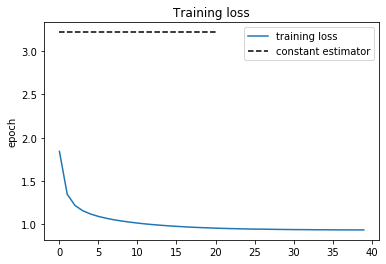

In [14]:
plt.figure()
plt.plot(range(num_epochs), history.history['loss'], label='training loss')
plt.hlines(baseline_accuracy, 0, 20, linestyles='dashed', label='constant estimator')
plt.title("Training loss")
plt.ylabel("CEE")
plt.ylabel("epoch")
plt.legend()

# Example Prediction

In [15]:
prefixes = ["Greifswal",
            "Was für ein sc",
            "Er ging hinei",
            "Gebe es ihr zur",
            "hatten es vers",
            "Sollbruchstell",
            "Hier ist der Satz zu Ende",
            "zu seine",
            "keine Angs"]
seqlst = []
for line in prefixes:
    x = charseq2idxseq(line)
    seqlst.append(x)

x_test = tf.keras.preprocessing.sequence.pad_sequences(
    seqlst, padding="post", maxlen=100, value = -1)

x_test = x_test + 1
out = rnn_simple(x_test)
ml_chars = tf.math.argmax(out, axis=-1)
for i, line in enumerate(prefixes):
    t = len(line)
    j = ml_chars[i, t]
    nextchar = alphabet[j]
    print(f"Predicted extension of '{line}':'{nextchar}'")

Predicted extension of 'Greifswal':'d'
Predicted extension of 'Was für ein sc':'h'
Predicted extension of 'Er ging hinei':'n'
Predicted extension of 'Gebe es ihr zur':'ü'
Predicted extension of 'hatten es vers':'c'
Predicted extension of 'Sollbruchstell':'e'
Predicted extension of 'Hier ist der Satz zu Ende':' '
Predicted extension of 'zu seine':'m'
Predicted extension of 'keine Angs':'t'
